In [ ]:
#!pip install -U pymoo

Inportação das bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import keras
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pymoo.visualization.scatter import Scatter

Carregar o dataset na variável data

In [ ]:
data = pd.read_csv("data/Credit.csv")
data

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,'no checking',12,'existing paid',furniture/equipment,1736,<100,4<=X<7,3,'female div/dep/mar',none,...,'real estate',31,none,own,1,'unskilled resident',1,none,yes,good
996,<0,30,'existing paid','used car',3857,<100,1<=X<4,4,'male div/sep',none,...,'life insurance',40,none,own,1,'high qualif/self emp/mgmt',1,yes,yes,good
997,'no checking',12,'existing paid',radio/tv,804,<100,>=7,4,'male single',none,...,car,38,none,own,1,skilled,1,none,yes,good
998,<0,45,'existing paid',radio/tv,1845,<100,1<=X<4,4,'male single',none,...,'no known property',23,none,'for free',1,skilled,1,yes,yes,bad


Transformar atributos categóricos em numéricos

In [ ]:
cat_columns = list(data.select_dtypes(include=['object']).columns)
le = LabelEncoder()
for col in cat_columns:
    data[col] = le.fit_transform(data[col])


Dividir os dados em treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.iloc[:, :-1],
    data.iloc[:, -1],
    test_size=0.3,
    random_state=0
)

Utilizar os scaler nos dados para proximar os valores

In [ ]:
num_columns = list(set(data.columns) - set(cat_columns))
scaler = MinMaxScaler()
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

### Primeiro teste: perda x acurácia
Criar a classe do Problema a ser otimizado

In [ ]:
class NeuralNetworkProblem(Problem):

  def __init__(self, x_train, y_train):
    super().__init__(n_var=2, n_obj=2, n_constr=0, xl=[30, 10], xu=[60, 20])
    self.x_train = x_train
    self.y_train = y_train

  def _evaluate(self, x, out, *args, **kwargs):
    loss = []
    accuracy = []
    for linha in x:
      model = keras.Sequential([
          keras.layers.Dense(linha[0], activation="relu", input_shape=(20,)),
          keras.layers.Dense(linha[1], activation="relu"),
          keras.layers.Dense(1, activation="sigmoid")
      ])
      model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
      model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=False)

      l, a = model.evaluate(self.x_train, self.y_train, verbose=False)
      loss.append(l)
      accuracy.append(-a)

    out["F"] = np.column_stack([loss, accuracy])

Rotina de otimização do problema

In [ ]:
problem = NeuralNetworkProblem(X_train, y_train)
algorithm = NSGA2(
    pop_size=100,
)
res = minimize(
    problem,
    algorithm,
    ("n_gen", 100),
    verbose=True,
    save_history=True,
    seed=1
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      5 |             - |             -
     2 |      200 |      6 |  0.4000008345 |         ideal
     3 |      300 |      6 |  0.0785399089 |             f
     4 |      400 |      5 |  0.0570334430 |             f
     5 |      500 |      4 |  0.0581127654 |             f
     6 |      600 |      5 |  0.0911023268 |             f
     7 |      700 |      4 |  0.0860071431 |             f
     8 |      800 |      4 |  0.000000E+00 |             f
     9 |      900 |      4 |  0.000000E+00 |             f
    10 |     1000 |      4 |  0.000000E+00 |             f
    11 |     1100 |      4 |  0.0815878653 |         ideal
    12 |     1200 |      4 |  0.000000E+00 |             f
    13 |     1300 |      4 |  0.000000E+00 |             f
    14 |     1400 |      4 |  0.000000E+00 |             f
    15 |     1500 |      4 |  0.000000E+00 |             f
    16 |     1600 |      3 |  0.2182564058 |         ide

Fronteira de pareto para o problema

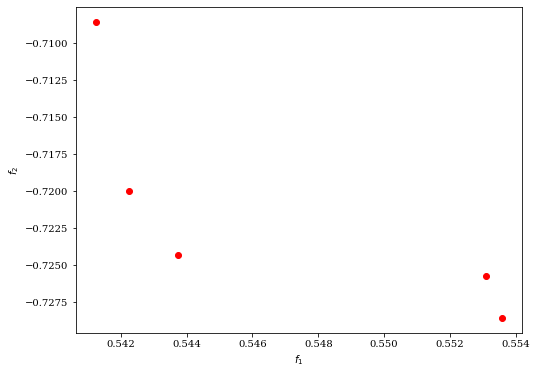

In [ ]:
F = res.F
plot = Scatter()
plot.add(F, color="red")
plot.show()

In [ ]:
res.F

array([[ 0.55356705, -0.72857141],
       [ 0.54124087, -0.70857143],
       [ 0.5530901 , -0.72571427],
       [ 0.54372376, -0.72428572],
       [ 0.54226232, -0.72000003]])

In [ ]:
res.X

array([[59.19715786, 16.91629432],
       [59.21561876, 18.7213297 ],
       [59.29965775, 18.27504458],
       [59.74235584, 16.37810606],
       [59.43278701, 19.29557425]])

Modelo escolhido:
* Primeira camada oculta: 59 neurônios
* Segunda camadad oculta: 16 neurônios

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(59, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=False)
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f'Testing accuracy: {accuracy}')

10/10 [==============================] - 0s 2ms/step
Testing accuracy: 0.7233333333333334


### Segundo teste: perda x norma dos pesos
Criar a classe do Problema a ser otimizado

In [ ]:
class NeuralNetworkProblem(Problem):

  def __init__(self, x_train, y_train):
    super().__init__(n_var=2, n_obj=2, n_constr=0, xl=[30, 10], xu=[60, 20])
    self.x_train = x_train
    self.y_train = y_train

  def _evaluate(self, x, out, *args, **kwargs):
    loss = []
    norma = []
    for linha in x:
      model = keras.Sequential([
          keras.layers.Dense(linha[0], activation="relu", input_shape=(20,)),
          keras.layers.Dense(linha[1], activation="relu"),
          keras.layers.Dense(1, activation="sigmoid")
      ])
      model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
      model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=False)

      l, a = model.evaluate(self.x_train, self.y_train, verbose=False)
      loss.append(l)
      weights = model.get_weights()
      norma.append(np.linalg.norm(np.concatenate([w.flatten() for w in weights])))

      # Set the objectives
    out["F"] = np.column_stack([loss, norma])

Rotina de otimização do problema

In [ ]:
problem = NeuralNetworkProblem(X_train, y_train)
algorithm = NSGA2(
    pop_size=50,
)
res = minimize(
    problem,
    algorithm,
    ("n_gen", 100),
    verbose=True,
    save_history=True,
    seed=1
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      5 |             - |             -
     2 |      100 |     10 |  0.1474879349 |         ideal
     3 |      150 |      5 |  0.0944444787 |             f
     4 |      200 |      6 |  0.0113235553 |         ideal
     5 |      250 |      7 |  0.0203624293 |         ideal
     6 |      300 |      7 |  0.000000E+00 |             f
     7 |      350 |      7 |  0.000000E+00 |             f
     8 |      400 |      8 |  0.0032829881 |             f
     9 |      450 |      8 |  0.000000E+00 |             f
    10 |      500 |      8 |  0.000000E+00 |             f
    11 |      550 |      7 |  0.0121698334 |             f
    12 |      600 |      7 |  0.000000E+00 |             f
    13 |      650 |      7 |  0.000000E+00 |             f
    14 |      700 |      7 |  0.000000E+00 |             f
    15 |      750 |      5 |  0.0210544677 |         ideal
    16 |      800 |      5 |  0.0085564957 |            

Fronteira de Pareto

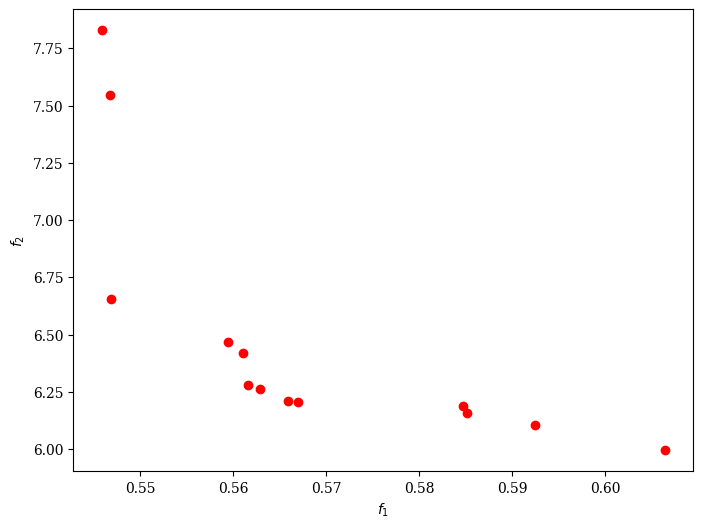

In [ ]:
F = res.F
plot = Scatter()
plot.add(F, color="red")
plot.show()

In [ ]:
res.F

array([[0.56155127, 6.27907658],
       [0.54688579, 6.65292978],
       [0.60645503, 5.99435902],
       [0.5669688 , 6.20376778],
       [0.54584938, 7.82829428],
       [0.56291425, 6.26140881],
       [0.56105262, 6.41770077],
       [0.55939704, 6.46698761],
       [0.58509302, 6.15718794],
       [0.59244591, 6.10330486],
       [0.5658946 , 6.21117496],
       [0.54674876, 7.54641485],
       [0.58467555, 6.1874342 ]])

In [ ]:
res.X

array([[30.15609578, 10.01129984],
       [40.16144893, 10.67994542],
       [30.75652423, 10.07456039],
       [30.46719517, 10.28075878],
       [52.89637181, 19.34578981],
       [30.15609578, 10.21176546],
       [30.75652423, 10.0056082 ],
       [31.65872074, 10.81499661],
       [30.12211617, 10.1380726 ],
       [30.00165817, 10.00178599],
       [30.02789991, 10.42359309],
       [49.76741214, 18.79315408],
       [30.01959649, 10.46498245]])

Modelo escolhido:
* Primeira camada oculta: 30 neurônios
* Segunda camada oculta: 10 neurônios

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=False)
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f'Testing accuracy: {accuracy}')

10/10 [==============================] - 0s 2ms/step
Testing accuracy: 0.71
